In [1]:
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import data.dataset as ds
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import model_ae_FD as vae


/home/lai075/miniconda3/envs/hf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Welcome to eht-imaging! v 1.2.8 



In [2]:
if False:
    model = vae.Vae_FD().to(device)
    model = torch.load('../models/model.pt').to(device)
    model.eval()


In [3]:
# plot all images in the batch
def plot_images(images):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
    fig.subplots_adjust(hspace=0., wspace=0.)
    axes = axes.flatten()
    for ax, img in zip(axes, images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')


In [4]:
# Randomly split the dataset into training and validation sets and then save

if False:
    import glob

    files = glob.glob('data/datasets/v3/imgs_*.npy')

    for f in files:
        data = np.load(f)
        np.random.shuffle(data)
        train_size = int(len(data) * 0.8)
        val_size = len(data) - train_size
        train_data, val_data = data[:train_size], data[train_size:]
        np.save(f.replace('imgs_', 'train/train_'), train_data)
        np.save(f.replace('imgs_', 'val/val_'), val_data)
        print(f, train_data.shape, val_data.shape)

In [5]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.01
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

train_transforms = v2.Compose([
    v2.ToTensor(),
    # gauss_noise_tensor,
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(90, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.GaussianBlur(3, sigma=(0.1, 0.5)),
    v2.CenterCrop(64),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(64),
])

Loading text image:  ./data/template_sgra.txt
Loading text image:  ./data/template_sgra.txt
torch.Size([32, 992])


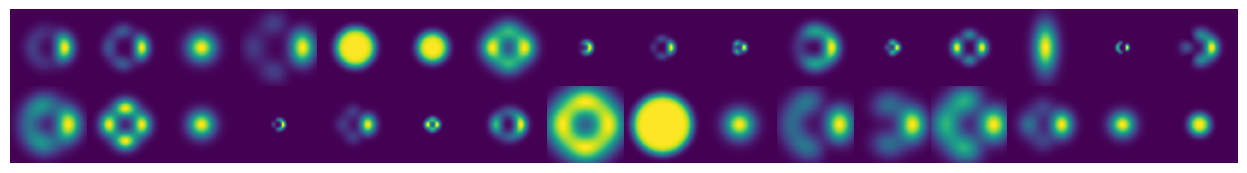

In [6]:
batch_size = 32

data_dir = 'data/datasets/v2/'
mnames = ['gauss', 'disk', 'ring', 'mring', 'ellipse']

filenames = np.array([data_dir + 'train/train_' + m + '.npy' for m in mnames])
train_data = ds.ImgDataset(filenames, transform=train_transforms, ehtim=True, tint_sec=5, tadv_sec=600, tstart_hr=0, tstop_hr=24)

filenames = np.array([data_dir + 'val/val_' + m + '.npy' for m in mnames])
val_data = ds.ImgDataset(filenames, transform=val_transforms, ehtim=True, tint_sec=5, tadv_sec=600, tstart_hr=0, tstop_hr=24)

train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val = DataLoader(val_data, batch_size=batch_size, shuffle=True)

if True:
    dataiter = iter(val)
    images, cis, classes = next(dataiter)
    print(cis.shape)

    plot_images(images)

    if False:
        with torch.inference_mode():
            features_vae, features_q, features_ci, recon_img, pred_img, pred_class = model(images.to(device), cis.to(device))
            plot_images(recon_img.cpu().detach())
            plot_images(pred_img.cpu().detach())


        

In [56]:
# test decoder from ci
from torch import nn

test = np.random.random_sample((10, 120, 1, 1))

decoder = nn.Sequential(
    nn.ConvTranspose2d(120, 64, 4, 1, 0),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(64, 32, 4, 2, 1),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(32, 4, 4, 2, 1),
)

out = decoder(torch.tensor(test, dtype=torch.float32))
print(out.shape)

test = np.random.random_sample((10, 120))

# turn it into a tensor of shape 120 x1 x1
test = torch.Tensor(test)
test = test.unsqueeze(2).unsqueeze(3)
print(test.shape)


torch.Size([10, 4, 16, 16])
torch.Size([10, 120, 1, 1])


In [6]:
# save images as jpegs
import glob

files = glob.glob('data/datasets/v2/imgs_*.npy')
i = 0 
for f in files:
    data = np.load(f)
    for n, img in enumerate(data):
        plt.imsave(f.replace('imgs_', 'jpegs/').replace('.npy', '_{}.jpg'.format(n)), img)
        i += 1
    print(f, data.shape)

data/datasets/v2/imgs_disk.npy (512, 128, 128)
data/datasets/v2/imgs_mring.npy (9180, 128, 128)
data/datasets/v2/imgs_gauss.npy (512, 128, 128)
data/datasets/v2/imgs_ellipse.npy (2048, 128, 128)
data/datasets/v2/imgs_ring.npy (1024, 128, 128)
